# Predviđanje cijena nafte koristeći Monte Carlo simulacije


Autor: [Roko Fumić](rfumic@unipu.hr)

Kolegij: Modeliranje i simulacije

Nositelj: Izv. prof. dr. sc. Darko Etinger

Asistent: Romeo Šajina, mag. inf.

_Sveučilište Jurja Dobrile u Puli_

_Fakultet Informatike u Puli_

# 1. Učitavanje podataka
Izvor podataka: [U.S Energy Information Administration](https://www.eia.gov/dnav/pet/hist/RBRTED.htm)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
%matplotlib inline

In [2]:
# ucitavanje podataka iz CSV datoteke
data = pd.read_csv(
    "Europe_Brent_Spot_Price_FOB.csv",
    skiprows=4, 
    index_col=[0], parse_dates=[0])
# odabir vremenskog raspona i okretanje redoslijeda
prices = data.loc["06/13/2012":"06/13/2022"].iloc[::-1]

prices.head()    

,Europe Brent Spot Price FOB Dollars per Barrel
Day,
2012-06-13,97.29
2012-06-14,96.46
2012-06-15,97.13
2012-06-18,95.21
2012-06-19,95.14


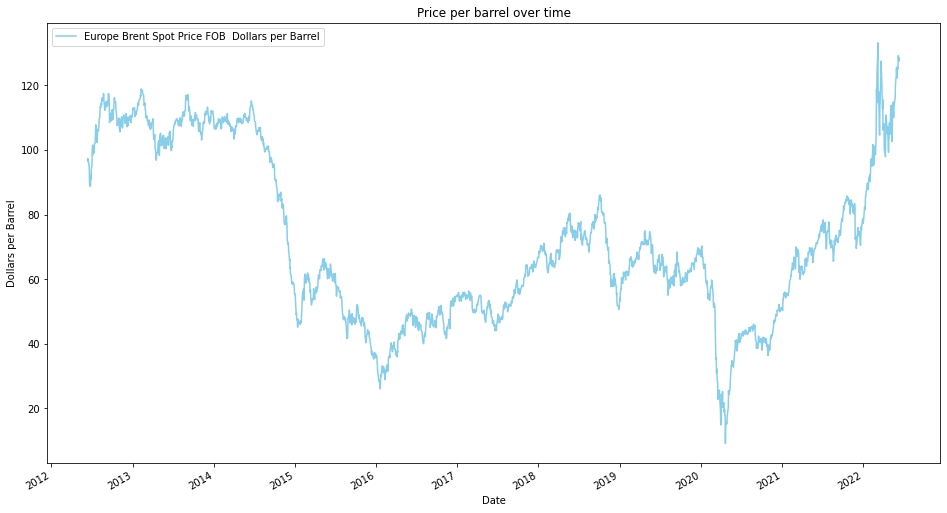

In [4]:
plt.rcParams['figure.figsize'] = [16, 9]

# graf stvarnih podataka
prices.plot(xlabel="Date", ylabel="Dollars per Barrel", title="Price per barrel over time" , color="skyblue")
plt.show()

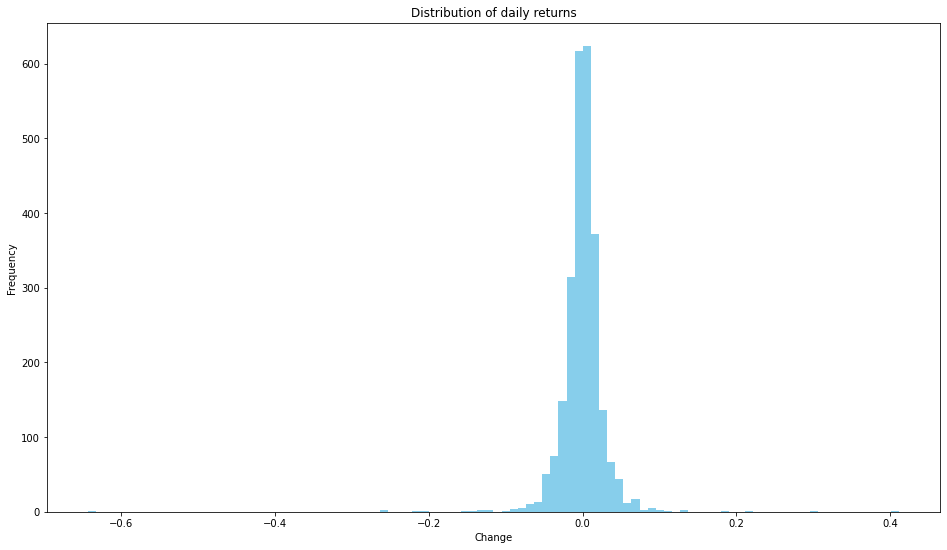

In [5]:
# Distribucija dnevnih stopa povrata
stope_povrata = np.log(1 + prices.pct_change())

plt.hist(stope_povrata,color="skyblue",bins=100)
plt.xlabel("Change")
plt.ylabel("Frequency") 
plt.title("Distribution of daily returns")
plt.show()

# 2. Izračun potrebnih varijabli

Složena godišnja stopa rasta predstavlja povratnu stopu koja je potrebna da neka investicija od početne vrijednosti dosegne krajnju vrijednost u nekom vremenskom razdoblju.
 
Definira se kao:
$$
    CAGR({t_0},{t_n}) = (\frac{V({t_n})}{V({t_0})})^\frac{1}{{t_n}-{t_0}} - 1
$$

gdje je $V({t_0})$ početna vrijednost, $V({t_n})$ konačna vrijednost, a $t_n - t_0$ broj godina. 

In [6]:
# helper za dohvacanje vrijednosti iz pandas series objekta
value = lambda x : x.values[0]

# V(t_n)/V(t_0) -> ukupan postotak rasta 
postotak_rasta = prices.iloc[-1] / prices.iloc[1]

# t_n - t_0 -> broj godina u rasponu ≈ ukupan broj dana / 365
broj_godina = ((prices.index[-1] - prices.index[0]).days) / 365.0

# slozena godisnja stopa rasta
cagr = value(postotak_rasta ** (1 / broj_godina) - 1)

print("Slozena godisnja stopa rasta (CAGR): " + str(round(cagr,2)))

Slozena godisnja stopa rasta (CAGR): 0.03


In [8]:
# volatilnost za 1 trading year -> standardna devijacija * √trading_days
trading_days = 252
std_dev = value(prices.pct_change().std()) * math.sqrt(trading_days)

print ("Standardna devijacija: ", str(round(std_dev,2)))

Standardna devijacija:  0.47


# 3. Generiranje nasumičnih vrijednosti

In [9]:
# generiranje nasumicnih vrijednosti stopa povrata za jednu godinu 
# s normalnom distribucijom

dnevne_stope = np.random.normal(cagr/trading_days, std_dev/math.sqrt(trading_days), trading_days)+1

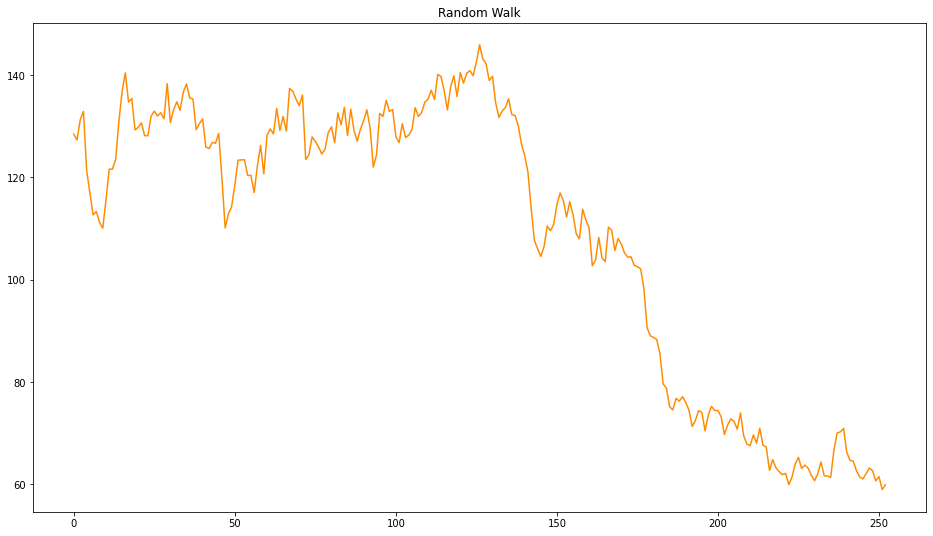

In [10]:
# generirane postotke primjenjujemo na pocevsi od posljednjeg dana
# "RANDOM WALK"

price_series = [prices.iloc[-1]]

for i in dnevne_stope:
    price_series.append(price_series[-1] * i)

plt.plot(price_series,color="darkorange")
plt.title("Random Walk")
plt.show()

# 4. Simuliranje nad većim brojem uzoraka

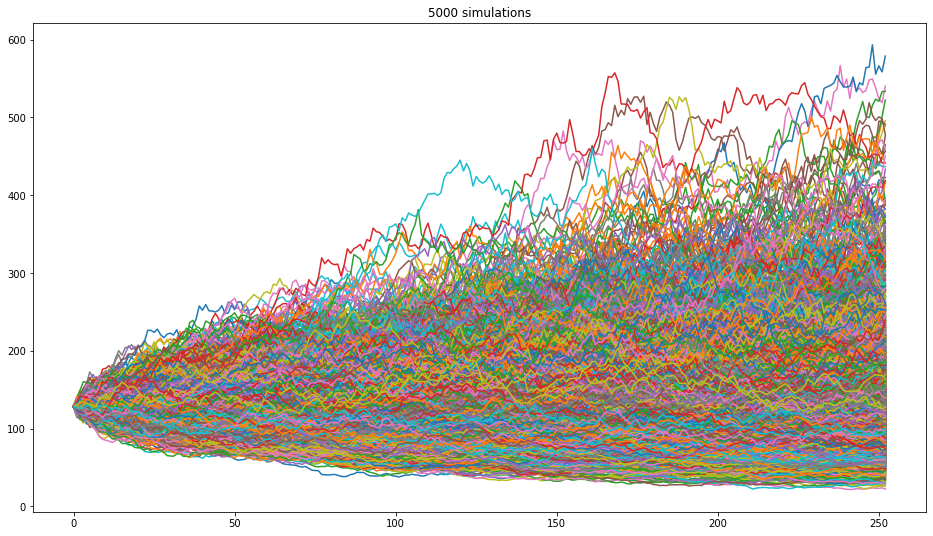

In [12]:
closing_prices = []
broj_simulacija = 5000

# generiranje nasumicnih dnevnih povratnih stopa prema normalnoj distribuciji
for i in range(broj_simulacija):
    dnevne_stope = np.random.normal(
        cagr/trading_days,
        std_dev/math.sqrt(trading_days),
        trading_days) + 1
    
    price_series = [prices.iloc[-1]]
    
    for j in dnevne_stope:
        price_series.append(price_series[-1] * j)
        
    closing_prices.append(price_series[-1].values[0])
    
    plt.plot(price_series)

plt.title(f"{broj_simulacija} simulations")
plt.show()

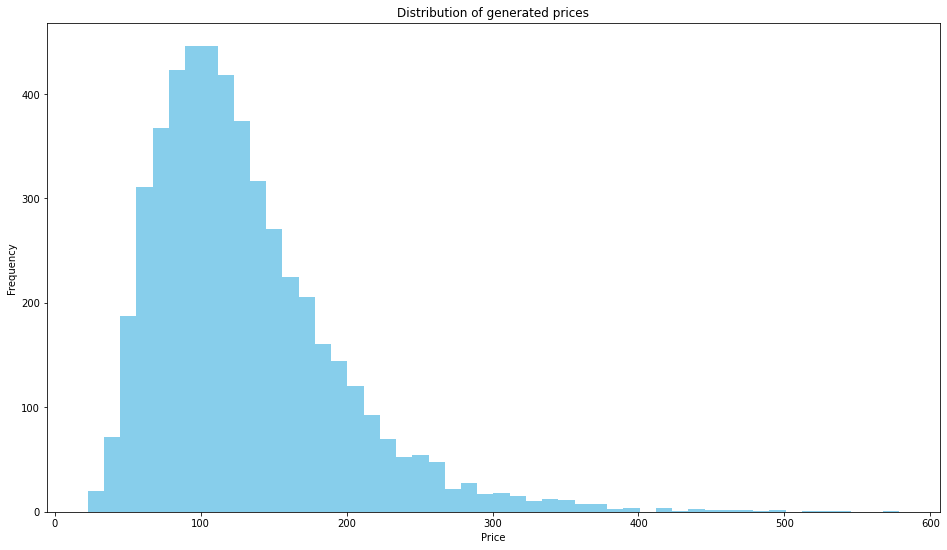

In [13]:
#histogram generiranih cijena

plt.hist(closing_prices,color="skyblue",bins=50)
plt.title("Distribution of generated prices")
plt.xlabel("Price")
plt.ylabel("Frequency") 
plt.show()

# 5. Analiza dobivenih rezultata

Računajuči prosjek krajnjih cijena dobivamo najvjerojatniju krajnju cijenu.

In [14]:
mean_end_price = round(np.mean(closing_prices),2)
print("Ocekivana cijena: ", str(mean_end_price))

Ocekivana cijena:  130.48


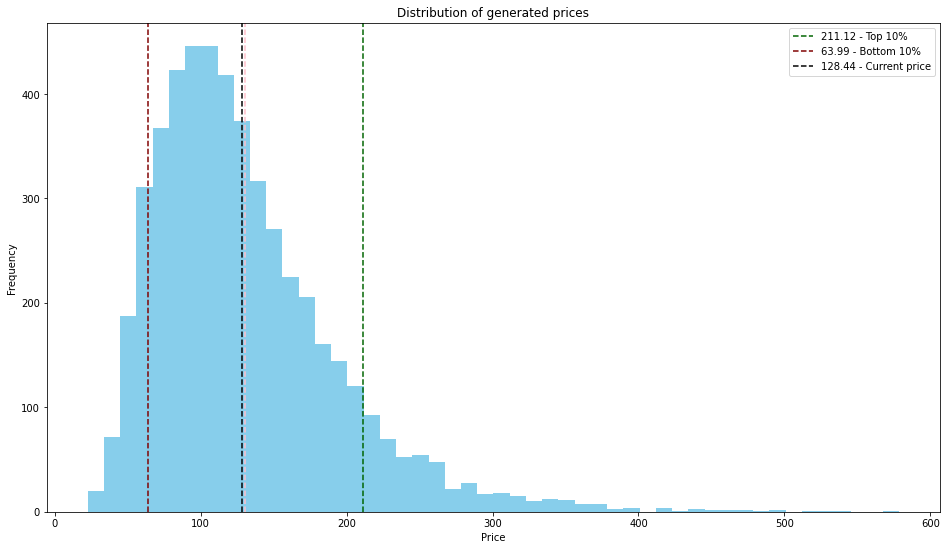

In [15]:
# 10% najboljih ishoda
gornjih_10 = np.percentile(closing_prices,100-10)


# 10% najgorih ishoda
donjih_10 = np.percentile(closing_prices,10);


trenutna_cijena = value(prices.iloc[-1])

# histogram ukljucujuci najbolje i najgore ishode

plt.hist(closing_prices,color="skyblue",bins=50)
plt.axvline(gornjih_10,color="darkgreen",linestyle="dashed")
plt.axvline(donjih_10,color="maroon",linestyle="dashed")
plt.axvline(trenutna_cijena,color="black", linestyle="dashed")
plt.axvline(mean_end_price,color="pink", linestyle="dashed")
plt.legend(labels =[f"{round(gornjih_10,2)} - Top 10%",f"{round(donjih_10,2)} - Bottom 10%",f"{trenutna_cijena} - Current price"]);
plt.title("Distribution of generated prices")
plt.xlabel("Price")
plt.ylabel("Frequency") 

plt.show()

# 4. Zaključak 

Distribucija cijena generiranih Monte Carlo simulacijom nam govori da bi se cijene nafte u idućih godinu dana trebale kretati ispod i u blizini trenutne cijene bez ekstremnih padova, ali s mogućim blažim porastima.